In [8]:
import sys
sys.path.append('./scripts/')
from puddle_world import *
import itertools 
import collections 
from copy import copy

In [9]:
class DynamicProgramming: 
    def __init__(self, widths, goals, puddles, time_interval, sampling_num, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goals = goals
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.value_function, self.final_state_flags =  self.init_value_function() 
        self.policy = self.init_policy()
        self.actions = list(set([tuple(self.policy[i]) for i in self.indexes]))
  #      self.actions = [(0.0, 2.0), (0.0, -2.0), (1.0, 0.0), (-1.0, 0.0)]
        
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        self.depths = self.depth_means(puddles, sampling_num)
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
    def value_iteration_sweep(self): #追加
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                max_q = -1e100
                max_a = None
                qs = [self.action_value(a, index) for a in self.actions] #全行動の行動価値を計算
                max_q = max(qs)                               #最大の行動価値
                max_a = self.actions[np.argmax(qs)]   #最大の行動価値を与える行動
                
                delta = abs(self.value_function[index] - max_q)            #変化量
                max_delta = delta if delta > max_delta else max_delta #スイープ中で最大の変化量の更新
                
                self.value_function[index] = max_q      #価値の更新
                self.policy[index] = np.array(max_a).T  #方策の更新
            
        return max_delta        
        
    def policy_evaluation_sweep(self):   
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                q = self.action_value(tuple(self.policy[index]), index)
                
                delta = abs(self.value_function[index] - q)
                max_delta = delta if delta > max_delta else max_delta
                
                self.value_function[index] = q
            
        return max_delta
    
    def action_value(self, action, index, out_penalty=True): 
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]: 
            after, out_reward = self.out_correction(np.array(index).T + delta)
            after = tuple(after)
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval + out_reward*out_penalty
            value += (self.value_function[after] + reward) * prob

        return value
            
    def out_correction(self, index): #変更
        out_reward = 0.0
        index[2] = (index[2] + self.index_nums[2])%self.index_nums[2] #方角の処理
        
        for i in range(2):
            if index[i] < 0:
                index[i] = 0
                out_reward = -1e100
            elif index[i] >= self.index_nums[i]:
                index[i] = self.index_nums[i]-1
                out_reward = -1e100
                
        return index, out_reward
        
    def depth_means(self, puddles, sampling_num):
        ###セルの中の座標を均等にsampling_num**2点サンプリング###
        dx = np.linspace(0, self.widths[0], sampling_num) 
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) #深さの合計が計算されて入る
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            for s in samples:
                pose = self.pose_min + self.widths*np.array([xy[0], xy[1], 0]).T + np.array([s[0], s[1], 0]).T #セルの中心の座標
                for p in puddles:
                    tmp[xy] += p.depth*p.inside(pose) #深さに水たまりの中か否か（1 or 0）をかけて足す
                        
            tmp[xy] /= sampling_num**2 #深さの合計から平均値に変換
                       
        return tmp
    
    def init_state_transition_probs(self, time_interval, sampling_num):
        ###セルの中の座標を均等にsampling_num**3点サンプリング###
        dx = np.linspace(0.001, self.widths[0]*0.999, sampling_num) #隣のセルにはみ出さないように端を避ける
        dy = np.linspace(0.001, self.widths[1]*0.999, sampling_num)
        dt = np.linspace(0.001, self.widths[2]*0.999, sampling_num)
        samples = list(itertools.product(dx, dy, dt))
        
        ###各行動、各方角でサンプリングした点を移動してインデックスの増分を記録###
        tmp = {}
        for a in self.actions:
            for i_t in range(self.index_nums[2]):
                transitions = []
                for s in samples:
                    before = np.array([s[0], s[1], s[2] + i_t*self.widths[2]]).T + self.pose_min  #遷移前の姿勢
                    before_index = np.array([0, 0, i_t]).T                                                      #遷移前のインデックス
                
                    after = IdealRobot.state_transition(a[0], a[1], time_interval, before)   #遷移後の姿勢
                    after_index = np.floor((after - self.pose_min)/self.widths).astype(int)   #遷移後のインデックス
                    
                    transitions.append(after_index - before_index)                                  #インデックスの差分を追加
                    
                unique, count = np.unique(transitions, axis=0, return_counts=True)   #集計（どのセルへの遷移が何回か）
                probs = [c/sampling_num**3 for c in count]                   #サンプル数で割って確率にする
                tmp[a,i_t] = list(zip(unique, probs))
                
        return tmp
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goals[0])
            
        return tmp
        
    def init_value_function(self): 
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            for goal in self.goals:
                f[index] = self.final_state(goal, np.array(index).T)
                v[index] = goal.value if f[index] else -100.0
                if f[index]:
                    break
                
        return v, f
        
    def final_state(self, goal, index):
        x_min, y_min, _ = self.pose_min + self.widths*index          #xy平面で左下の座標
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1) #右上の座標（斜め上の離散状態の左下の座標）
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] #4隅の座標
        return all([goal.inside(np.array(c).T) for c in corners ])

In [10]:
import seaborn as sns   ###dp2exec

puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)]
goals = [Goal(1,4), Goal(4,1), Goal(-4,-4)]
dp = DynamicProgramming(np.array([0.2, 0.2, math.pi/18]).T, goals, puddles, 0.1, 10, puddle_coef=1000000.0) 
counter = 0 #スイープの回数

In [11]:
delta = 1e100

while delta > 0.01: 
    delta = dp.value_iteration_sweep()
    counter += 1
    print(counter, delta)

1 21193.28880712346
2 20573.95350178686
3 20305.780909497138
4 20265.778797349958
5 20132.69033845191
6 20090.4316723753
7 19983.8702112678
8 18552.343129336572
9 17695.1228236694
10 15588.249937086977
11 12043.257338646916
12 11254.040414719362
13 11210.080870897116
14 10720.550720332016
15 10715.648508155282
16 10707.183770751464
17 10695.93445538968
18 10670.254866531468
19 10535.445171093277
20 8285.091846739466
21 6477.969196434919
22 4641.431287139538
23 3820.345996160817
24 2548.299559602514
25 1975.039597645984
26 1450.167376849713
27 1055.3388787753065
28 763.6335616039578
29 547.8717594241898
30 389.17909129697364
31 273.52145596948685
32 190.1217632627231
33 130.64011742424918
34 88.66105567701743
35 59.31181459239451
36 38.94938655337319
37 24.896663443447324
38 15.221456635859795
39 8.55496044154279
40 7.296612993610324
41 7.242287933302578
42 7.216089704976184
43 7.210336162490421
44 7.145638627524022
45 7.022908641170943
46 6.8846530381415505
47 6.640693346475018
48 6.31

In [12]:
with open("./data/dp_observation_policy.txt", "w") as f:  ###dp2writepolicy
    for index in dp.indexes:
        p = dp.policy[index]
        f.write("{} {} {} {} {}\n".format(index[0], index[1], index[2], p[0], p[1]))
        
with open("./data/dp_observation_value.txt", "w") as f:
    for index in dp.indexes:
        p = dp.value_function[index]
        f.write("{} {} {} {}\n".format(index[0], index[1], index[2], p))

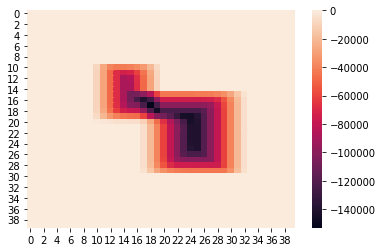

In [6]:
%matplotlib inline
v = dp.value_function[:, :, 18]  ###dp1valuedraw
sns.heatmap(np.rot90(v), square=False)
plt.show()

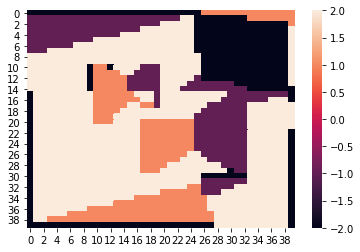

In [7]:
p = np.zeros(dp.index_nums) ###dp1policydraw
for i in dp.indexes:
    p[i] = sum(dp.policy[i]) #速度と角速度を足すと、1.0: 直進、2.0: 左回転、-2.0: 右回転になる

sns.heatmap(np.rot90(p[:, :, 18]), square=False) #180〜190[deg]の向きのときの行動を図示
plt.show()